In [2]:
%pylab inline

'''
Nearly all of the following code is based off the following paper:
http://www.flam3.com/flame_draves.pdf
Note that only a very few of the referenced transforms are implemented here,
but implementing more is trivial, so if you want to have fun, have at it!
'''

# This section is purely setup and imports. Note that not all imports

import numpy as np
import scipy as sc
import scipy.misc
import scipy.ndimage
import scipy.interpolate
#import theano
#import theano.tensor as T
#from theano import shared
from tqdm import tqdm
import random

from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [169]:
default_condense_args = {
    'xmin': -1,
    'xmax': 1,
    'ymin': -1,
    'ymax': 1,
    'xres': 1440,
    'yres': 1080,
    'gamma': 2.0,
    'vibrancy': 0.0,
    'supersample': 2,
    'saturation': None, # or a real value
    'contrast': None, # or a real value
}
make_get = lambda d: lambda k: d[k] if k in d else default_condense_args[k]
theano_dtype = 'float32'

def make_condense(**condense_args):
    '''
    Take a 2D histogram of where points have landed
    This is actually a wrapper function to store the parameters for the histogram, just so
    we're not re-extracting parameters every iteration (not really a big deal, but still)
    '''
    get = make_get(condense_args)
    xmin = get('xmin')
    xmax = get('xmax')
    ymin = get('ymin')
    ymax = get('ymax')
    xres = get('xres')
    yres = get('yres')
    supersample = get('supersample')
    def condense(x, y, c):
        return np.stack([np.histogram2d(x, y, weights=c[:,channel],
                                        bins=[yres*supersample, xres*supersample],
                                        range=[[ymin, ymax], [xmin, xmax]])[0]
                         for channel in range(4)],
                        axis=2)
    return condense
    

def prepare_image(condensed, **condensed_args):
    '''
    Given a linear histogram of where points have landed, render that to an image
    Condensed is a 3D matrix of shape HEIGHT x WIDTH x 4 (RGBA)
    '''
    get = make_get(condensed_args)
    
    # Some pixels have never had a point land in them, which causes computational issues later
    # Create and store a mask of all such pixels so they can be corrected as needed
    mask = condensed == 0
    mask = np.prod(mask, axis=2)
    mask = np.logical_not(np.stack([mask] * 4, axis=2))
    if np.any(mask):
        condensed[mask] = condensed[mask] - np.min(condensed[mask])
    condensed[~mask] = 0
    mask[:,:,:-1] |= True
    condensed[~mask] = 1
    
    # Scale colors by log(alpha)/alpha
    color_scale = condensed[:, :, -1]
    color_scale = np.log(color_scale) / color_scale
    color_scale = np.expand_dims(color_scale, 2)
    condensed = condensed * color_scale
    condensed[~mask] = 1
    
    # Apply gamma correction
    gamma = get('gamma')
    vibrancy = get('vibrancy')
    per_color = condensed ** (1 / gamma)
    vibrancy_factors = condensed[:, :, -1] ** (1 / gamma)
    vibrancy_factors = np.log(vibrancy_factors) / vibrancy_factors
    vibrancy_factors = np.expand_dims(vibrancy_factors, 2)
    vibrant = condensed * vibrancy_factors
    condensed = vibrancy * vibrant + (1 - vibrancy) * per_color
    #condensed[~mask] = 1
    condensed[np.isnan(condensed)] = 0
    
    # Apply saturation boost if requested
    if get('saturation') is not None or get('contrast') is not None:
        condensed = saturate(condensed, **condensed_args)
        
    # Resolve supersampling
    scale = 1/get('supersample')
    condensed = scipy.ndimage.zoom(condensed, zoom=(scale, scale, 1))
    
    return condensed

def display_flame(condensed, **condensed_args):
    if condensed is None:
        raise RuntimeError("Cannot draw None")
    get = make_get(condensed_args)
    xmin = get('xmin')
    xmax = get('xmax')
    ymin = get('ymin')
    ymax = get('ymax')
    condensed = prepare_image(condensed, **condensed_args)
    fixed = (condensed - condensed.min()) / condensed.ptp()
    fixed[:,:,-1] = 1
    
    plt.figure(figsize=(10, 14))
    # Work-around, until I figure out what's up with pyplot
    plt.imshow(fixed, aspect='equal', interpolation='bicubic')
    #sc.misc.imsave('tmp.png', fixed, format='png')
    #plt.imshow(plt.imread('tmp.png'), aspect='equal', interpolation='nearest')
    plt.show(block=False)
    
def save_flame(condensed, name, **condensed_args):
    condensed = prepare_image(condensed, **condensed_args)
    condensed[np.isnan(condensed)] = 0
    png = '.png' if not name.endswith('.png') else ''
    jpg = '.jpg' if not name.endswith('.jpg') else ''
    sc.misc.imsave(name + png, condensed)
    sc.misc.imsave(name + jpg, condensed)
    #fixed = (condensed - condensed.min()) / condensed.ptp()
    #plt.imsave("pl_" + name, fixed)
    
    
#xy = np.random.uniform(low=-1.0, high=1.0, size=(1000000, 2))
#z = np.expand_dims(np.sin(xy[:,0] * xy[:,1] * 100), axis=1)
#xyz = np.hstack([xy, z])
#display_flame(condense(xyz))

In [159]:
# Skip over this, I've just put this here to get it out of the relevant code
# These functions are purely image modifications to bring out more color
# They have nothing to do with the interesting parts of rendering the fractal

def saturate(condensed, **condensed_args):
    '''
    Boost the saturation of image x by x^(1/saturation)
    '''
    saturation = make_get(condensed_args)('saturation')
    contrast = make_get(condensed_args)('contrast')
    
    # Convert from RGB to HSL
    size = tuple(condensed.shape[:2])
    rgb = condensed[:,:,:3]
    a = condensed[:,:,3]
    
    a = (a - np.min([0, np.min(a)])) / np.max([np.max(a), np.ptp(a)])
    
    #http://www.niwa.nu/2013/05/math-behind-colorspace-conversions-rgb-hsl/
    mn = np.min([0, np.min(rgb)])
    ptp = np.max([np.max(rgb), np.ptp(rgb)])
    rgb = (rgb-mn) / ptp
    r = rgb[:,:,0]
    g = rgb[:,:,1]
    b = rgb[:,:,2]
    
    mn = np.min(rgb, axis=2)
    mx = np.max(rgb, axis=2)
    
    l = (mn + mx) / 2
    
    s1 = (mx-mn)/(mx+mn)
    s2 = (mx-mn)/(2-mx-mn)
    s = np.zeros(size)
    s[l < 0.5] = s1[l < 0.5]
    s[l >= 0.5] = s2[l >= 0.5]
    
    h = np.zeros(size)
    r_max = r == mx
    g_max = g == mx
    b_max = b == mx
    h[r_max] = 0 + (g[r_max] - b[r_max]) / (mx[r_max] - mn[r_max])
    h[g_max] = 2 + (b[g_max] - r[g_max]) / (mx[g_max] - mn[g_max])
    h[b_max] = 4 + (r[b_max] - g[b_max]) / (mx[b_max] - mn[b_max])
    h /= 6
    h[np.isnan(h)] = 0
    
    # Boost channels
    if saturation is not None:
        s = s ** (1 / saturation)
    if contrast:
        half = np.ptp(l) / 2
        mean = np.min(l) + half
        l = (l - mean) / half
        l[l > 0] = l[l > 0] ** (1 / contrast)
        l[l < 0] = -((-l[l < 0]) ** (1 / contrast))
        l = l * half + mean
    
    # Convert from HSL to RGB
    #http://www.niwa.nu/2013/05/math-behind-colorspace-conversions-rgb-hsl/
    t11 = l * (1 + s)
    t12 = l + s - l * s
    t1 = np.zeros(size)
    t1[l < 0.5] = t11[l < 0.5]
    t1[l >= 0.5] = t12[l >= 0.5]
    t2 = 2 * l - t1
    
    def lim(t):
        t = np.copy(t)
        t[t > 1] -= 1
        t[t < 0] += 1
        return t
    tr = lim(h + (1/3))
    tg = lim(h)
    tb = lim(h - (1/3))
    
    def run_test(tmp):
        test1 = (6 * tmp) <= 1
        test2 = ~test1 & ((2 * tmp) <= 1)
        test3 = ~test1 & ~test2 & (3 * tmp <= 2)
        res = np.ones(size) * t2
        res[test1] = t2[test1] + (t1[test1] - t2[test1]) * 6 * tmp[test1]
        res[test2] = t1[test2]
        res[test3] = t2[test3] + (t1[test3] - t2[test3]) * (2/3 - tmp[test3]) * 6
        res[s <= 0] = l[s <= 0]
        return res
    r = run_test(tr)
    g = run_test(tg)
    b = run_test(tb)
    
    return np.stack([r, g, b, a], axis=2)


In [175]:
def chaos_game(fs, f_final=None, n=1000000, n_runs=1, iters=200, min_iter=20, and_display=True, resume=None, **condense_args):
    '''
    The Chaos Game is simple (https://en.wikipedia.org/wiki/Chaos_game)
    1) Pick a random point (x,y)
    2) Apply a random transform F to it
    3) Record where it lands (in terms of pixels)
    4) Repeat a lot
    The Flame algorithm tweaks this to include 3 color channels per point
    This results in four histograms, one for each color channel, one for alpha (alpha for a point is 1)
    This implementation is a vectorized approach that runs n points simultaneously
    Note that the result is the same, since for a single iteration, the function applied to a point
    is still randomly chosen per-point
    '''
    condensed = resume
    fs = [(var, weight) for f in fs for var, weight in f]
    fs, weights = zip(*fs)
    # Launching with the same parameters should result in the same color scheming
    np.random.seed(hash(tuple(fs)) % 0xffffffff)
    weights /= np.sum(weights)
    num_fs = len(fs)
    range_fs = list(range(num_fs))
    # Assign a random color to each transform
    colors = np.random.uniform(low=0, high=1, size=(num_fs, 3))
    colors = np.hstack([colors, np.ones((num_fs, 1))])
    color_final = np.random.uniform(low=0, high=1, size=3)
    color_final = np.hstack([color_final, [1]])
    
    np.random.seed()
    condense = make_condense(**condense_args)
    for run in range(n_runs):
        # Pick n random points
        x = np.random.uniform(low=-1.0, high=1.0, size=n)
        y = np.random.uniform(low=-1.0, high=1.0, size=n)
        xf = np.copy(x)
        yf = np.copy(y)
        # Assign each a random starting color
        c = np.random.uniform(low=0,    high=1.0, size=(n, 4))
        cf = np.copy(c)
        for it in tqdm(range(iters)):
            # Pick a transform for each point
            f_choices = np.random.choice(range_fs, p=weights, replace=True, size=n)
            for f in range(num_fs):
                # For all points affected by transform f, apply f
                sel = f_choices == f
                x[sel], y[sel] = fs[f](x[sel], y[sel])
                if f_final is not None:
                    xf[sel], yf[sel] = f_final(x[sel], y[sel])
                else:
                    xf[sel], yf[sel] = x[sel], y[sel]
                # Shift these points' colors toward f's color
                c[sel] = (c[sel] + colors[f]) / 2
                # Shift skew toward a universal color
                cf[sel] = (c[sel] + color_final) / 2
            # Render this iteration of points
            if it >= min_iter:
                condensed = condense(xf, yf, cf) + (condensed if condensed is not None else 0)
            if type(and_display) == int and it >= min_iter and it % and_display == 0:
                display_flame(condensed, **condense_args)
    if and_display:
        display_flame(condensed, **condense_args)
    return condensed

In [181]:
class Var():
    '''
    Every variation takes the form of the following function:
    F(x, y) = V_p(a*x + b*y + c, d*x + e*y + f)
    Where V_p is some parametrized function that takes 2D points and returns 2D points
    Note that V_p does not have to be linear (and most of the ones below aren't)
    This class simplifies the definition of new variations by implementing the a-f transformation
    step, then calling V_p, while also storing what a-f and the parameters p are, thus allowing
    this class to be called simply as "my_custom_variation(x, y)", and all other parameters are
    automatically made available to V_p
    Also, since Python allows "func(*params)", you can name your extra parameters whatever you want
    E.g., def my_custom_var(x, y, a, b, c, d, e, f, theta, epsilon, foobar): ...
    Use the @variation decorator below to create Var instances from V_p functions
    NOTE: When implementing V_p, DO NOT perform the a*x+b*y+...+f transform, this is pre-applied
    to x, y before they get passed to V_p
    '''
    def __init__(self, func, num_params, a, b, c, d, e, f, *p):
        dargs = np.random.randn(6)
        self.args = [a, b, c, d, e, f]
        self.args = [v if v is not None else dv for v, dv in zip(self.args, dargs)]
        a, b, c, d, e, f = tuple(self.args)
        p = [p[i] if i < len(p) else np.random.randn() for i in range(num_params)]
        #@jit
        def pre(x, y):
            return a * x + b * y + c, d * x + e * y + f
        self.p = list(p)
        self.all_params = self.args + self.p
        self.func = func #jit(func)
        self.pre = pre
        #print("Initialized %s with %d parameters (%s)" % (func.__name__, num_params, ",".join("%f" % param for param in self.all_params)))
        
    def __call__(self, x, y):
        x, y = self.pre(x, y)
        return self.func(x, y, *self.all_params)
    
    def __str__(self):
        return "%s (%s)" % (self.func.__name__, 
                            ",".join("%f" % param for param in self.all_params))
    
    def __len__(self):
        return 1
    
    def weights(self):
        return [1]
    
    def __iter__(self):
        return iter([(self, 1)])
    
    def __hash__(self):
        return hash(tuple([self.func.__name__] + self.all_params))
    
    def visualize(self, default_params=True):
        num = 30
        xs = np.linspace(-1, 1, num=num, endpoint=True)
        ys = xs
        xs, ys = np.meshgrid(xs, ys)
        if not default_params:
            xs, ys = self.pre(xs, ys)
        all_args = ([1,0,0,0,1,0] + [1 for p in self.p]) if default_params else self.all_args
        xs, ys = self.func(xs, ys, *all_args)
        ys *= -1 # To match how images are displayed
        fig = plt.figure(figsize=(4,4))
        style = 'b-'
        for col in range(num):
            plt.plot(xs[:,col], ys[:,col], style)
        style = 'r-'
        for row in range(num):
            plt.plot(xs[row,:], ys[row,:], style)
        plt.title(self.func.__name__)
        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        plt.show(block=False)
        
    def sample(self, **kwargs):
        '''
        This doesn't really work well... need to find a way to demonstrate a variation
        without all the points exploding away from [-1,1], and with something reliably good
        '''
        default_args = {'xres': 640, 'yres': 480, 'supersample': 1, 'and_display': True, 'n': 10000, 'iters': 100}
        default_args.update(**kwargs)
        print(self.func.__name__)
        # Repeating itself allows for multiple colors to arise
        chaos_game([self]*3, **default_args)
        
all_variations = []
def variation(func_or_num_params=None):
    '''
    This is a function decorator that can optionally be parametrized
    @variation == @variation(0), so I'll just describe @variation(n)
    Use variation to decorate a function with the following signature:
    def my_custom_var(x, y, a, b, c, d, e, f, ...)
    variation converts this into the equivalent of the following signature:
    def initialize_my_custom_var(a, b, c, d, e, f, ...):
        def my_custom_var(x, y):
            ...
        return my_custom_var
    This allows you to initialize parametric variations, and then use them as simple 2D transforms
    '''
    if isinstance(func_or_num_params, int): 
        num_params = func_or_num_params
        func = None
    else:
        num_params = 0
        func = func_or_num_params
        
    if func is None:
        def make_variation(func):
            def inner(a=None, b=None, c=None, d=None, e=None, f=None, *p):
                return Var(func, num_params, a, b, c, d, e, f, *p)
            all_variations.append(inner)
            return inner
        return make_variation
    else:
        def inner(a=None, b=None, c=None, d=None, e=None, f=None, *p):
            return Var(func, num_params, a, b, c, d, e, f, *p)
        all_variations.append(inner)
        return inner

class Transform():
    '''
    Transforms are probabilistic collections of variations, with some extra fluff
    When a transform is called with x, y, it selects a random variation and runs it for that instance
    This can also integrate symmetry, including handling selection weighting to ensure that
    symmetry is properly represented in the final result
    Note that when a transform is given to the Chaos Game, it's actually unrolled, so
    each variation inside of it is handled separately (selection probabilities are retained)
    '''
    def __init__(self, *variations, weights=None, rotational_sym=1, dihedral_sym=False):
        n = len(variations)
        if n == 0:
            raise RuntimeError("Transform must have at least one variation")
        
        if weights is None:
            weights = np.random.uniform(size=len(variations))
        elif weights == 1:
            weights = np.ones(len(variations))
        else:
            if not len(weights) == len(variations):
                raise RuntimeError("Number of variations and weights for a Transform must be equal")
        
        weights = list(weights)
        variations = list(variations)
        
        total_weight = np.sum(weights)
        if dihedral_sym:
            variations.append(dihedral())
            weights.append(total_weight)
            total_weight *= 2
            
        for rot in range(rotational_sym-1):
            theta = 2 * np.pi * (rot + 1) / rotational_sym
            variations.append(rotate(theta))
            weights.append(total_weight)
        
        self.variations = variations
        self.weights = weights / np.sum(weights)
        
        print("Initialized transform: %s" % ", ".join(str(var) for var in self.variations))
        
#     def __call__(self, x, y):
#         num_fs = len(self.variations)
#         f_choices = np.random.choice(range(num_fs), p=self.weights, size=x.shape[0])
#         for f in range(num_fs):
#             sel = f_choices == f
#             x[sel], y[sel] = self.variations[f](x[sel], y[sel])
#         return x, y
    
    def __str__(self):
        return "Transform<%s>" % (";".join(str(var) for var in self.variations))
    
    def __len__(self):
        return len(self.variations)
    
    def weights(self):
        return self.weights
    
    def __iter__(self):
        return iter([(trans, w1 * w2) for var, w1 in zip(self.variations, self.weights) for trans, w2 in var])
    
# ==================================================
# The actual transforms
# ==================================================
sin = np.sin
cos = np.cos
pi = np.pi
arctan = np.arctan2
sqrt = np.sqrt
choice = np.random.choice
uniform = np.random.uniform
def _r2(x, y):
    return x * x + y * y
def _r(x, y):
    return sqrt(_r2(x, y))
def _theta(x, y):
    return arctan(x, y)
def _phi(x, y):
    return arctan(y, x)
def _omega(size):
    return choice([0, pi], size=size)
def _alpha(size):
    return choice([-1, 1], size=size)
def _unif(size):
    return uniform(low=0, high=1, size=size)
def _trunc(v):
    return np.trunc(v)
    
@variation # can also be @variation() or @variation(0)
def identity(x, y, a, b, c, d, e, f):
    return x, y

rotate = lambda theta: identity(cos(theta), -sin(theta), 0, sin(theta), cos(theta), 0)
dihedral = lambda: identity(-1, 0, 0, 0, 1, 0)


@variation
def sinusoidal(x, y, a, b, c, d, e, f):
    return sin(x), cos(y)

@variation
def spherical(x, y, a, b, c, d, e, f):
    ir = 1 / _r2(x, y)
    return ir * x, ir * y

@variation(4)
def pdj(x, y, a, b, c, d, e, f, p1, p2, p3, p4):
    return sin(p1 * y) - cos(p2 * x), sin(p3 * x) - cos(p4 * y)

@variation
def handkerchief(x, y, a, b, c, d, e, f):
    r = _r(x, y)
    t = _theta(x, y)
    return r * sin(t + r), r * cos(t - r)

@variation
def disc(x, y, a, b, c, d, e, f):
    td = _theta(x, y) / pi
    r = _r(x, y)
    return td * sin(pi * r), td * cos(pi * r)

@variation
def polar(x, y, a, b, c, d, e, f):
    r = _r(x, y)
    t = _theta(x, y)
    return t / pi, r - 1

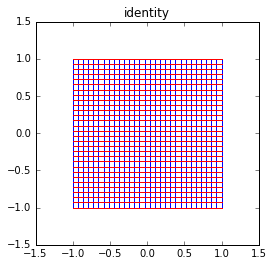

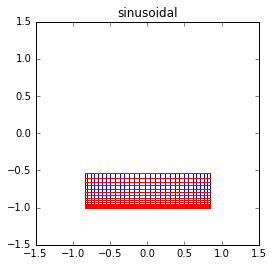

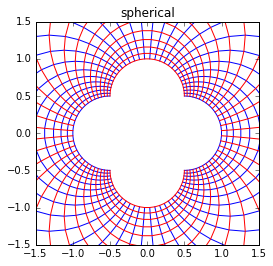

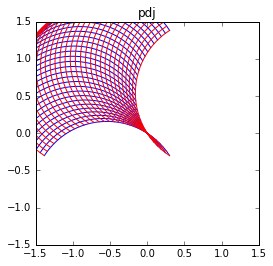

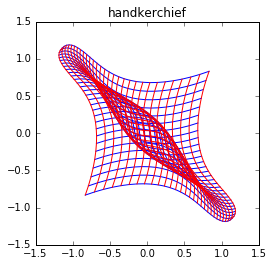

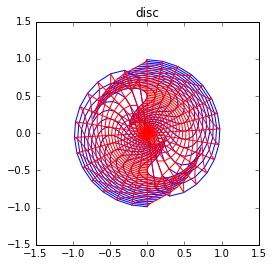

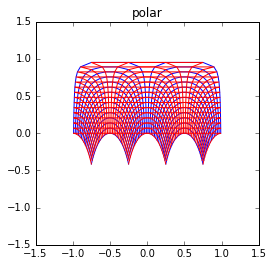

In [174]:
# Run this to see how the variations behave
for vari in all_variations:
    vari().visualize()

C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: invalid value encountered in sqrt
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: invalid value encountered in sqrt


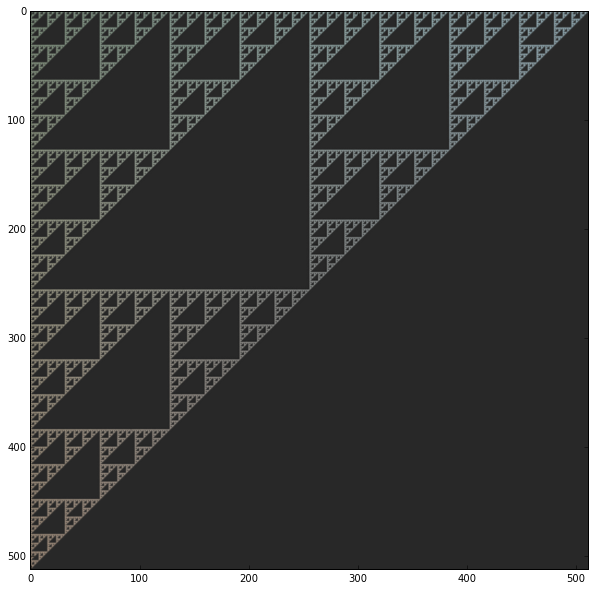

C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:70: RuntimeWarning: divide by zero encountered in log
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:72: RuntimeWarning: invalid value encountered in multiply


In [168]:
# Sierpinski's Gasket (https://en.wikipedia.org/wiki/Sierpinski_triangle)
# This is a common fractal that can be rendered, among other ways, using the chaos game
# I put it here to demonstrate how to do something obvious and known, and also to test the renderer
# NOTE: I don't think the Mandelbrot set can be rendered this way :'(

@variation
def gasket0(x, y, *crap):
    return x/2, y/2

@variation
def gasket1(x, y, *crap):
    return (x+1)/2, y/2

@variation
def gasket2(x, y, *crap):
    return x/2, (y+1)/2
gasket0 = gasket0(1, 0, 0, 0, 1, 0)
gasket1 = gasket1(1, 0, 0, 0, 1, 0)
gasket2 = gasket2(1, 0, 0, 0, 1, 0)

def sierpinski_gasket(**display_args):
    c = chaos_game([gasket0, gasket1, gasket2], **display_args)
    save_flame(c, 'sierpinski_gasket')

sierpinski_gasket(iters=30, n=100000, xmin=0, xmax=1, ymin=0, ymax=1, xres=512, yres=512)

  0%|          | 0/200 [00:00<?, ?it/s]

Initialized transform: identity (0.333627,-0.011600,0.122022,1.474773,-0.282366,-0.019071), sinusoidal (0.158999,0.591594,-0.135336,-2.601749,-1.839360,0.282662), pdj (0.865580,-0.093428,1.167846,-1.204897,1.654749,-0.151793,-0.348983,-0.144542,-0.490991,0.984298), handkerchief (1.044544,-1.256289,1.540197,-0.019603,2.063945,0.788449), disc (-2.344722,0.355393,0.242555,0.224720,-0.257857,0.379219), identity (-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000)


 12%|█▎        | 25/200 [00:17<04:25,  1.52s/it]C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: invalid value encountered in sqrt
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: invalid value encountered in sqrt
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: invalid value encountered in true_divide


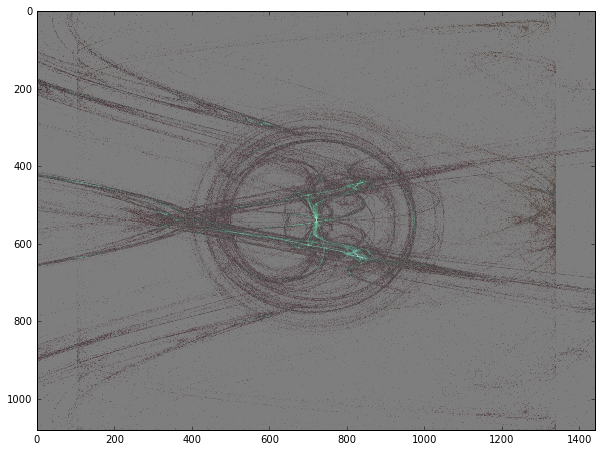

 25%|██▌       | 50/200 [01:11<04:22,  1.75s/it]C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:70: RuntimeWarning: divide by zero encountered in log
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:72: RuntimeWarning: invalid value encountered in multiply


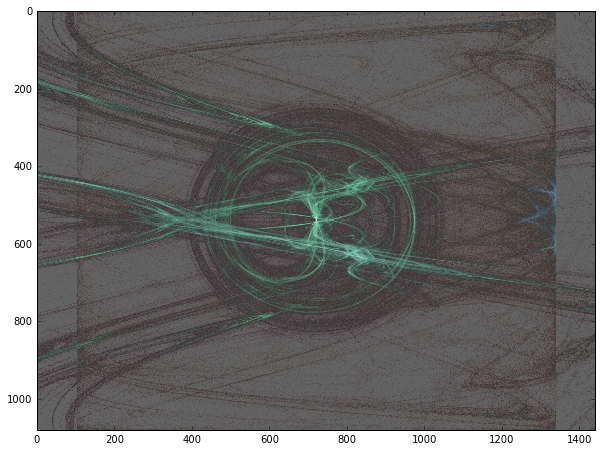

 30%|███       | 61/200 [01:42<04:20,  1.88s/it]

In [ ]:
# FINALLY, we can render some fractal flame art
# This cell sets up a new flame configuration and renders it

v1 = identity()
v2 = sinusoidal()
#v3 = spherical()
v4 = polar()
v5 = pdj()
v6 = handkerchief()
v7 = disc()
trans = [v1, v2, v5, v6, v7]
trans = Transform(*trans, dihedral_sym=True)
flame_settings = {
    'n': 1000000,
    'n_runs': 1,
    'iters': 200,
    'xmin': -1.166,
    'xmax': 1.166,
    'ymin': -1,
    'ymax': 1,
    'and_display': 25,
    'xres': 1440,
    'yres': 1080,
    'supersample': 2,
    'vibrancy': 2,
    'saturation': 2,
}
cond = chaos_game([trans], **flame_settings)

In [ ]:
# This cell demonstrates how to pick up where you left off and continue rendering 
# (creates new batch of points, but that doesn't really matter)
# (Make sure not to change any render parameters, only display parameters or run configurations)
flame_settings['resume'] = cond
flame_settings['n'] = 100000
flame_settings['iters'] = 100

cond = chaos_game([trans], **flame_settings)

C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: invalid value encountered in sqrt
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: invalid value encountered in sqrt
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:70: RuntimeWarning: divide by zero encountered in log
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: invalid value encountered in true_divide


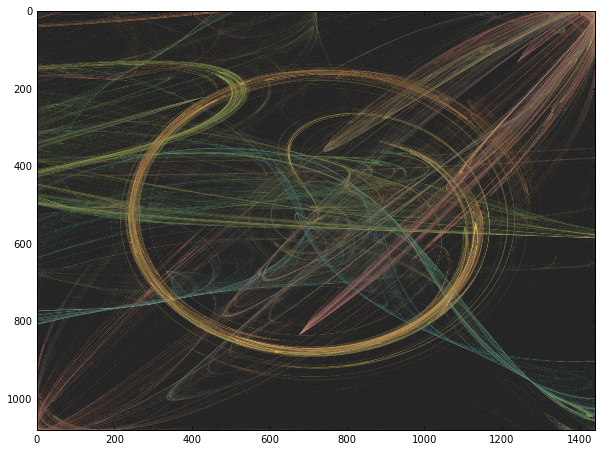

In [161]:
# This cell is for playing with display parameters without changing the render
display_flame(cond, vibrancy=1.0, saturation=2.0)

In [162]:
# Save the flame to an image file (saves both to png and jpg)
save_flame(cond, 'flame10', vibrancy=1.0, saturation=2.0)

C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: invalid value encountered in sqrt
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: invalid value encountered in sqrt
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:70: RuntimeWarning: divide by zero encountered in log
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
'''
TODO:
Implement density estimation
Animate
'''